# A Simple Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled datasets, we are going to disregard the labels for educational purposes and consider it as an unlabeled dataset.

In [1]:
#!pip install -r requirements.txt | grep -v "already"
#!pip install livelossplot

> After installing the dependencies you have to restart the kernel. The following cell does that for you, in case you forget.

In [2]:
#import IPython

#IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

In [3]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [5]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

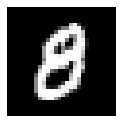

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into vectors of length 784. The images from this dataset are already normalized such that the values are between 0 and 1. 

Here you will build a simple autoencoder. 

The encoder and decoder should be made of simple Multi-Layer Perceptrons. The units that connect the encoder and decoder will be the _compressed representation_ (also called _embedding_).

Since the images are normalized between 0 and 1, you will need to use a **sigmoid activation on the output layer** to get values that match this input value range.

For this exercise you are going to use a dimension for the embeddings of 32.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim),

        )
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
        
        self.auto_encoder = nn.Sequential(
            nn.Flatten(),
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        encoded = self.auto_encoder(x)
        
        # Reshape the output as an image
        # remember that the shape should be (batch_size, channel_count, height, width)
        return encoded.reshape((x.shape[0], 1, 28, 28))
    
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)

---
## Loss Function

As explained in the lesson, we can use the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [8]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop, however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

For this simple autoencoder we do not need the GPU, so we will train on the CPU.

In [9]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [8]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.34it/s]


Epoch: 1 	Training Loss: 58.509973	Valid Loss: 31.556238


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  8.06it/s]


Epoch: 2 	Training Loss: 27.604407	Valid Loss: 23.344653


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.10it/s]


Epoch: 3 	Training Loss: 21.948181	Valid Loss: 18.901000


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.77it/s]


Epoch: 4 	Training Loss: 17.325456	Valid Loss: 15.603855


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.73it/s]


Epoch: 5 	Training Loss: 14.551903	Valid Loss: 13.114390


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.58it/s]


Epoch: 6 	Training Loss: 12.745158	Valid Loss: 11.849415


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.62it/s]


Epoch: 7 	Training Loss: 11.545671	Valid Loss: 11.156142


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.84it/s]


Epoch: 8 	Training Loss: 10.819299	Valid Loss: 10.444190


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.99it/s]


Epoch: 9 	Training Loss: 10.216539	Valid Loss: 9.871029


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.82it/s]


Epoch: 10 	Training Loss: 9.793652	Valid Loss: 9.478321


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.11it/s]


Epoch: 11 	Training Loss: 9.345220	Valid Loss: 9.047668


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.25it/s]


Epoch: 12 	Training Loss: 8.965895	Valid Loss: 8.796952


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.59it/s]


Epoch: 13 	Training Loss: 8.714316	Valid Loss: 8.637842


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.20it/s]


Epoch: 14 	Training Loss: 8.458811	Valid Loss: 8.294719


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.66it/s]


Epoch: 15 	Training Loss: 8.226384	Valid Loss: 8.190912


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.70it/s]


Epoch: 16 	Training Loss: 8.106829	Valid Loss: 8.136532


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.19it/s]


Epoch: 17 	Training Loss: 7.941971	Valid Loss: 7.796654


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.07it/s]


Epoch: 18 	Training Loss: 7.868265	Valid Loss: 7.776607


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.16it/s]


Epoch: 19 	Training Loss: 7.712004	Valid Loss: 7.749744


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.18it/s]


Epoch: 20 	Training Loss: 7.607897	Valid Loss: 7.609746


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.12it/s]


Epoch: 21 	Training Loss: 7.600792	Valid Loss: 7.809341


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.10it/s]


Epoch: 22 	Training Loss: 7.525202	Valid Loss: 7.588478


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.61it/s]


Epoch: 23 	Training Loss: 7.384449	Valid Loss: 7.398876


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.49it/s]


Epoch: 24 	Training Loss: 7.234630	Valid Loss: 7.237455


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.72it/s]


Epoch: 25 	Training Loss: 7.433400	Valid Loss: 7.437579


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  4.78it/s]


Epoch: 26 	Training Loss: 7.318654	Valid Loss: 7.274015


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.38it/s]


Epoch: 27 	Training Loss: 7.159010	Valid Loss: 7.205043


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.87it/s]


Epoch: 28 	Training Loss: 7.096229	Valid Loss: 7.149430


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.53it/s]


Epoch: 29 	Training Loss: 7.024999	Valid Loss: 7.241809


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.71it/s]


Epoch: 30 	Training Loss: 7.006235	Valid Loss: 7.024655


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch: 31 	Training Loss: 7.004782	Valid Loss: 7.190396


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  4.54it/s]


Epoch: 32 	Training Loss: 6.969092	Valid Loss: 6.943789


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.07it/s]


Epoch: 33 	Training Loss: 7.021635	Valid Loss: 7.506337


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.99it/s]


Epoch: 34 	Training Loss: 7.076611	Valid Loss: 7.099545


Validating: 100%|███████████████████████████████| 12/12 [00:02<00:00,  5.98it/s]


Epoch: 35 	Training Loss: 6.933098	Valid Loss: 6.956913


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.54it/s]


Epoch: 36 	Training Loss: 6.781286	Valid Loss: 6.963293


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.48it/s]


Epoch: 37 	Training Loss: 6.805853	Valid Loss: 6.794392


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.15it/s]


Epoch: 38 	Training Loss: 6.765174	Valid Loss: 6.831744


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.83it/s]


Epoch: 39 	Training Loss: 6.760764	Valid Loss: 6.999917


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.77it/s]


Epoch: 40 	Training Loss: 6.800042	Valid Loss: 6.774277


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.82it/s]


Epoch: 41 	Training Loss: 6.745577	Valid Loss: 6.983054


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.27it/s]


Epoch: 42 	Training Loss: 6.675670	Valid Loss: 6.877397


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.88it/s]


Epoch: 43 	Training Loss: 6.641707	Valid Loss: 6.819670


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.93it/s]


Epoch: 44 	Training Loss: 6.641038	Valid Loss: 6.742290


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.37it/s]


Epoch: 45 	Training Loss: 6.703644	Valid Loss: 6.861698


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.34it/s]


Epoch: 46 	Training Loss: 6.643703	Valid Loss: 6.697356


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.78it/s]


Epoch: 47 	Training Loss: 6.606144	Valid Loss: 6.736077


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.94it/s]


Epoch: 48 	Training Loss: 6.629481	Valid Loss: 6.744620


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.80it/s]


Epoch: 49 	Training Loss: 6.580857	Valid Loss: 6.844290


Validating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.00it/s]

Epoch: 50 	Training Loss: 6.608947	Valid Loss: 6.817874


## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [9]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].numpy(),
                    'reconstructed': outputs[i].numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████████████████████████████| 10/10 [00:01<00:00,  5.63it/s]


,loss,image,reconstructed
0,0.005759,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0004447815, 0.00055703527, 0.000676733, 0..."
1,0.010696,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0017779929, 0.0012139416, 0.0005708419, 0..."
2,0.003217,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00015150539, 0.00051627203, 0.0003657938,..."
3,0.008884,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0014303813, 0.0023908026, 0.0018380563, 0..."
4,0.009226,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0034249397, 0.0042135287, 0.0017284786, 0..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

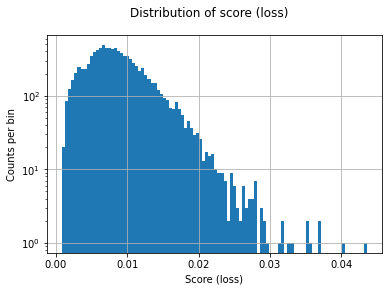

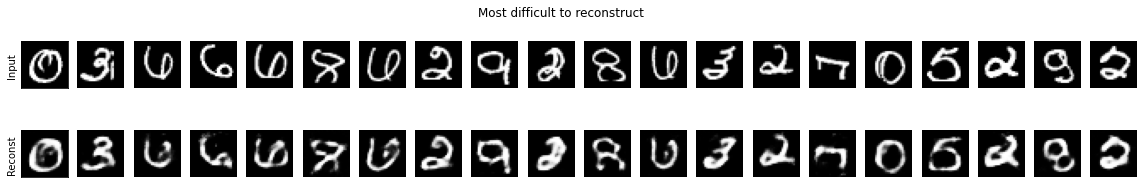

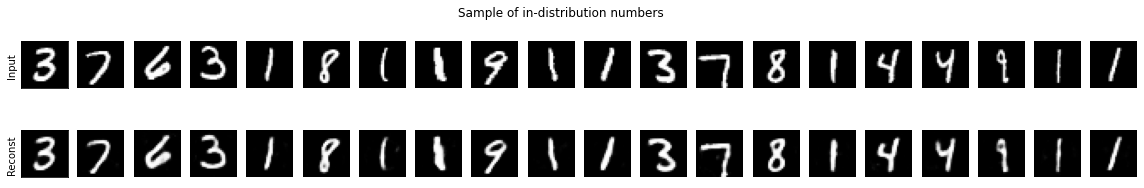

In [10]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

Each of the bottom panels has the input in the first row and the reconstruction in the second row. 

Let's look at the first of the two panels. The most difficult numbers to reconstruct (the "anomalies" with the highest loss) are indeed pretty particular: they have some noise (like the vertical lines in some of the numbers), or are just not standard ways of drawing the respective numbers. As a result, the reconstructed images (second row) are not matching the inputs very well and the loss is high. These are anomalies.

The second panel instead shows numbers taken from the peak of the distribution, and look indeed much more standard. The autoencoder can reconstruct them much better which result in a lower loss.

In summary, the reconstruction loss can be used as a score proportional to how much a certain example is typical: a low loss means a typical example; a high loss means an atypical example,an anomaly.

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.